# Logistic Regression for MNIST Data Set

A logistic regression for the 0s and 1s only from the MNIST dataset.

<img src="http://ufldl.stanford.edu/tutorial/images/Mnist_01.png"/>

Based on the [UFLDL tutorial](http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/) with a few key changes:

 - Matrix operations are used on the whole dataset (as a single batch given it is small), rather than loops on individual items.
 - Single training example x-values are row rather than column vectors (i.e. we use $y = x w^T + b$ not $y = w^T x + b$).

In [1]:
from torchvision import transforms, datasets
import torch
from torch import tensor
import doctest

## Data

This time we'll use DataLoaders for their batching functionality.

In [70]:
# Get the dataset from torchvision
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
train_dataset = datasets.MNIST("./data", train=True,  download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)

# Filter to those that are labelled as 0s or 1s
train_images_list = [i[0].flatten() for i in train_dataset if i[1] < 2] 
train_values_list = [tensor(i[1]) for i in train_dataset if i[1] < 2]
test_images_list = [i[0].flatten() for i in test_dataset if i[1] < 2] 
test_values_list = [tensor(i[1]) for i in test_dataset if i[1] < 2]
len(train_images_list)

12665

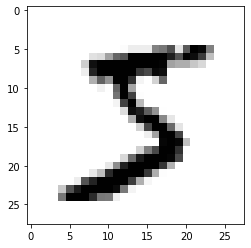

In [73]:
from matplotlib import pyplot
pyplot.imshow(train_dataset[0][0].squeeze(), cmap='gray_r')

In [72]:
train_x = torch.stack(train_images_list)
train_y = torch.stack(train_values_list).unsqueeze(1) # Make vertical tensor
test_x = torch.stack(test_images_list)
test_y = torch.stack(test_values_list).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12665, 784]), torch.Size([12665, 1]))

## Model

### Logistic Function (Sigmoid)

We now use sigmoid (`torch.sigmoid`) to constrain the predictions to a range of 0-to-1:

$
\begin{align}
P(y=1|x) &= h_\theta(x) = \frac{1}{1 + \exp(-x \theta^\top)}
\\
P(y=0|x) &= 1 - P(y=1|x) = 1 - h_\theta(x)
\end{align}
$

### Loss

For loss we will use negative log likelihood loss:

$
J(\theta) = - \sum_i \left(y^{(i)} \log( h_\theta(x^{(i)}) ) + (1 - y^{(i)}) \log( 1 - h_\theta(x^{(i)}) ) \right)
$

In [43]:
def nll_loss_binary(predictions: tensor, targets: tensor)-> float:
    """
    Binary Negative Log Likelihood Loss (2 output classes)
    
    Rather than taking an batch size x categories tensor, it just
    takes a batch size x 1 tensor as the prediction is simply either
    1 or 0.
    """
    left = targets * torch.log(predictions)
    right = (1 - targets) * torch.log(1 - predictions)
    negative_sum = - torch.sum(torch.stack([left, right]))
    return negative_sum.item()

# Test (expecting -ln(0.5*2) = 1.386)
nll_loss_binary(tensor([[0.5,], [0.5]]), tensor([[1.,], [0.]]))

1.3862943649291992

In [62]:
torch.sigmoid(tensor([-100]))

tensor([0.])

### Gradients

The gradient with respect to $\theta$ comes out exactly as with linear regression:

$
\nabla_\theta J(\theta) = \sum_i x^{(i)} (h_\theta(x^{(i)}) - y^{(i)})
$

In [123]:
def gradient_descent(inputs: tensor, targets: tensor, epochs: int, learning_rate: float) -> tensor:
    # Initialise random weights
    weights = torch.rand(1, inputs.shape[1], dtype=torch.float) / inputs.shape[1]
    
    for i in range(epochs):
        
        # Forward
        activations = inputs @ weights.T
        predictions = torch.sigmoid(activations)    
        number_predictions = predictions.shape[0]
        loss = nll_loss_binary(predictions, targets)
        
        # Backwards
        errors = predictions - targets
        gradients_weights = torch.matmul(errors.T, inputs) / number_predictions
        
        # Step
        weights -= gradients_weights * learning_rate
        
        if i == 0 or ((i + 1) % 10) == 0:
            print("Epoch: ", i + 1 , "loss: ", loss)
    
    return weights
    
trained_weights = gradient_descent(train_x, train_y, 100, .01)

Epoch:  1 loss:  9448.189453125
Epoch:  10 loss:  2822.199462890625
Epoch:  20 loss:  1676.8770751953125
Epoch:  30 loss:  1231.9415283203125
Epoch:  40 loss:  991.583984375
Epoch:  50 loss:  839.4447631835938
Epoch:  60 loss:  733.7098388671875
Epoch:  70 loss:  655.5446166992188
Epoch:  80 loss:  595.1697998046875
Epoch:  90 loss:  546.982666015625
Epoch:  100 loss:  507.5332336425781


## Test

Get accurancy, by calculating the number of correct predictions in the test dataset.

In [118]:
def check_accuracy(trained_weights: tensor, test_inputs: tensor, test_targets: tensor) -> float:
    activations = test_inputs @ trained_weights.T
    predictions = torch.sigmoid(activations)  
    
    # Get the predictions as most likely number (0 or 1), rather than probabilities
    predicted_1 = predictions > 0.5
    predicted_numbers = predicted_1.type(torch.int8)
    
    accurate_predictions = predicted_numbers == test_targets
    accuracy = torch.sum(accurate_predictions) / test_targets.shape[0]
    return accuracy.item()

# Test with random numbers
check_accuracy(torch.rand(1, test_x.shape[1], dtype=torch.float) / test_x.shape[1], test_x, test_y)

0.46335697174072266

In [124]:
check_accuracy(trained_weights, test_x, test_y)

0.9976359605789185

This is as expected (close to 100% accuracy as 0s and 1s are very different).